In [78]:
from PIL import Image, ImageOps
import numpy as np
import cv2
from PIL import Image, ImageOps
import torch
import random


def composite_images(img_a_path, img_a_matte_path, img_b_path, img_b_matte_path, scale_factor, position):
    # 加载图片A及其蒙版
    img_a = Image.open(img_a_path).convert("RGBA")
    img_a_matte = Image.open(img_a_matte_path).convert("L")

    # 加载图片B及其蒙版
    img_b = Image.open(img_b_path).convert("RGBA")
    img_b_matte = Image.open(img_b_matte_path).convert("L")

    # 缩放图片B及其蒙版
    new_size = (int(img_b.width * scale_factor), int(img_b.height * scale_factor))
    img_b_resized = img_b.resize(new_size, Image.Resampling.LANCZOS)
    img_b_matte_resized = img_b_matte.resize(new_size, Image.Resampling.LANCZOS)

    # 使用图片B的蒙版创建一个只有人物的版本（背景透明）
    img_b_person = Image.composite(img_b_resized, Image.new("RGBA", img_b_resized.size, (0, 0, 0, 0)), img_b_matte_resized)

    # 准备图片A的背景（保留背景，移除人物）
    img_a_background = Image.new("RGBA", img_a.size, (0, 0, 0, 0))
    img_a_inverted_matte = ImageOps.invert(img_a_matte.convert("RGB")).convert("L") # 蒙版反转
    img_a_background.paste(img_a, mask=img_a_inverted_matte)

    # 将图片B的人物放置到图片A的指定位置
    img_a_background.paste(img_b_person, position, img_b_person)

    # 将图片A的人物与合成的背景合并
    final_img = Image.new("RGBA", img_a.size)
    final_img.paste(img_a_background, (0,0)) # 首先粘贴背景和图片B的人物
    final_img.paste(img_a, (0,0), mask=img_a_matte) # 再粘贴图片A的人物

    # 显示或保存最终图像
    return final_img  # 或 final_img.save("output_path.png")

# 请注意，这段代码需要Pillow库的支持，确保在使用之前已经安装了Pillow库。


In [10]:
def composite_images_with_random_parameters_clipping_rotation_and_cropping(img_a_path, img_a_matte_path, img_b_path, img_b_matte_path):
    # 加载图片A以获取其尺寸
    img_a = Image.open(img_a_path).convert("RGBA")
    
    # 加载图片B
    img_b = Image.open(img_b_path).convert("RGBA")
    
    # 随机生成缩放因子，范围从0.5到1.5
    scale_factor = random.uniform(0.5, 1.5)

    # 如果scale_factor大于0.8，则对图片B进行随机裁剪
    if scale_factor > 0.8:
        # 计算裁剪尺寸，裁剪1/4到1/2的内容
        crop_width = random.uniform(0.3, 0.5)/scale_factor * img_b.width
        crop_height = random.uniform(0.3, 0.5)/scale_factor * img_b.height

        # 计算裁剪的起始位置
        start_x = random.randint(0, int(img_b.width - crop_width))
        start_y = random.randint(0, int(img_b.height - crop_height))

        # 应用裁剪
        img_b = img_b.crop((start_x, start_y, start_x + crop_width, start_y + crop_height))

    # 缩放图片B
    img_b_resized = img_b.resize((int(img_b.width * scale_factor), int(img_b.height * scale_factor)), Image.Resampling.LANCZOS)
    
    # 随机生成旋转角度，范围从-15到15度
    rotation_angle = random.uniform(-15, 15)
    
    # 旋转图片B
    img_b_rotated = img_b_resized.rotate(rotation_angle, expand=True)

    # 如果旋转后的图片B尺寸超过图片A，进行裁剪
    if img_b_rotated.width > img_a.width or img_b_rotated.height > img_a.height:
        img_b_rotated = img_b_rotated.crop((0, 0, min(img_a.width, img_b_rotated.width), min(img_a.height, img_b_rotated.height)))

    # 生成随机位置
    max_x_position = max(img_a.width - img_b_rotated.width, 0)
    max_y_position = max(img_a.height - img_b_rotated.height, 0)
    position = (random.randint(0, max_x_position), random.randint(0, max_y_position))

    # 调用原始合成函数
    return composite_images(img_a_path, img_a_matte_path, img_b_path, img_b_matte_path, scale_factor, position)
def composite_images_from_df(df):
    """
    从DataFrame中随机选择两张图片及其Alpha蒙版，并应用合成流程。
    
    参数:
    - df: 包含至少两组图片路径的DataFrame，有两列：'FG'和'Alpha'。
    
    返回:
    - PIL Image对象，表示合成后的图片。
    """
    
    # 确保df至少有两行
    if len(df) < 2:
        raise ValueError("DataFrame需要至少包含两行数据。")
    
    # 随机选择两个不同的索引
    idxs = random.sample(range(len(df)), 2)
    a, b = idxs[0], idxs[1]
    
    # 从DataFrame中读取路径
    a_img, a_alpha = df.iloc[a]['FG'], df.iloc[a]['Alpha']
    b_img, b_alpha = df.iloc[b]['FG'], df.iloc[b]['Alpha']
    
    # 调用合成函数
    return composite_images_with_random_parameters_clipping_rotation_and_cropping(
        img_a_path=a_img, img_a_matte_path=a_alpha,
        img_b_path=b_img, img_b_matte_path=b_alpha
    ),Image.open(df.iloc[a]['Alpha']),df.iloc[a]['FG'].split("/")[-1]


In [11]:
from datetime import datetime
import os
import uuid
from PIL import Image
import pandas as pd
import copy

# 在循环中

# 假设ReadImage类和composite_images_from_df函数已正确定义

def generate_composite_images(fg_dir, alpha_dir, target_dir, prefix, n,hot):
    # 确保目标目录存在
    if not os.path.isdir(fg_dir):
        raise FileNotFoundError(f"前景目录 '{fg_dir}' 不存在。")
    if not os.path.isdir(alpha_dir):
        raise FileNotFoundError(f"透明度蒙版目录 '{alpha_dir}' 不存在。")
    if not os.path.isdir(target_dir):
        raise FileNotFoundError(f"目标目录 '{target_dir}' 不存在。")
    # 读取图片和蒙版信息构建DataFrame
    # 注意：根据实际ReadImage类的实现调整下面的代码
    # files = ReadImage(fg_dir, alpha_dir).read_same_names()
    hots = torch.load(hot)
    # 存储生成的文件名
    generated_filenames = []
    
    for _ in range(n):
        # 执行合成操作，此处假设composite_images_from_df已经修改为返回两个Image对象
        composite_image, composite_alpha,base_name = composite_images_from_df(files)
        
        # 生成唯一的文件名
        unique_filename = f"{prefix}_{uuid.uuid4().hex}.png"
        generated_filenames.append(unique_filename)
        
        # 保存合成图和蒙版
        composite_image.save(os.path.join(fg_dir, unique_filename))
        composite_alpha.save(os.path.join(alpha_dir, unique_filename))
        hots[unique_filename] = copy.deepcopy(hots[base_name])
        
    # 保存文件名到文本文件
    today_str = datetime.now().strftime("%Y-%m-%d")
    filenames_file_path = os.path.join(target_dir, f"own_{today_str}.txt")
    torch.save(hots,hot)
    with open(filenames_file_path, 'w') as f:
        for filename in generated_filenames:
            f.write(f"{filename}\n")
    return generated_filenames

# 调用函数示例
# generate_composite_images('/path/to/fg', '/path/to/alpha', '/path/to/target', 'prefix', 5)


In [28]:
import os


def delete_listed_files(file_path, dir1, dir2):
    """
    删除两个目录下，文件名列在file_path中的所有文件，最后删除file_path文件。

    参数:
    - file_path: 包含要删除的文件名列表的文件路径。
    - dir1, dir2: 包含需要删除文件的目录路径。
    """
    try:
        # 打开文件并读取文件名列表
        with open(file_path, 'r') as file:
            filenames = file.read().splitlines()
        
        # 在两个目录中循环删除文件
        for dir in [dir1, dir2]:
            for filename in filenames:
                try:
                    # 构建完整的文件路径
                    full_path = os.path.join(dir, filename)
                    # 如果文件存在，则删除
                    if os.path.exists(full_path):
                        os.remove(full_path)
                        print(f"已删除文件: {full_path}")
                    else:
                        print(f"未找到文件: {full_path}")
                except Exception as e:
                    print(f"删除文件 {full_path} 时出错: {e}")

        # 最后删除包含文件名列表的文件本身
        os.remove(file_path)
        print(f"已删除文件列表: {file_path}")
    
    except Exception as e:
        print(f"处理文件 {file_path} 时出错: {e}")

# 示例调用
# delete_listed_files('path/to/filenames_file.txt', '/path/to/dir1', '/path/to/dir2')


In [81]:
from wraptrain import ReadImage
base_path = "/mnt/data/human/Test/"
fg = base_path+"Comp"
matte= base_path+"Alpha"
files = ReadImage(fg,matte).read_same_names()

In [82]:
#aaa=composite_images_from_df(files)

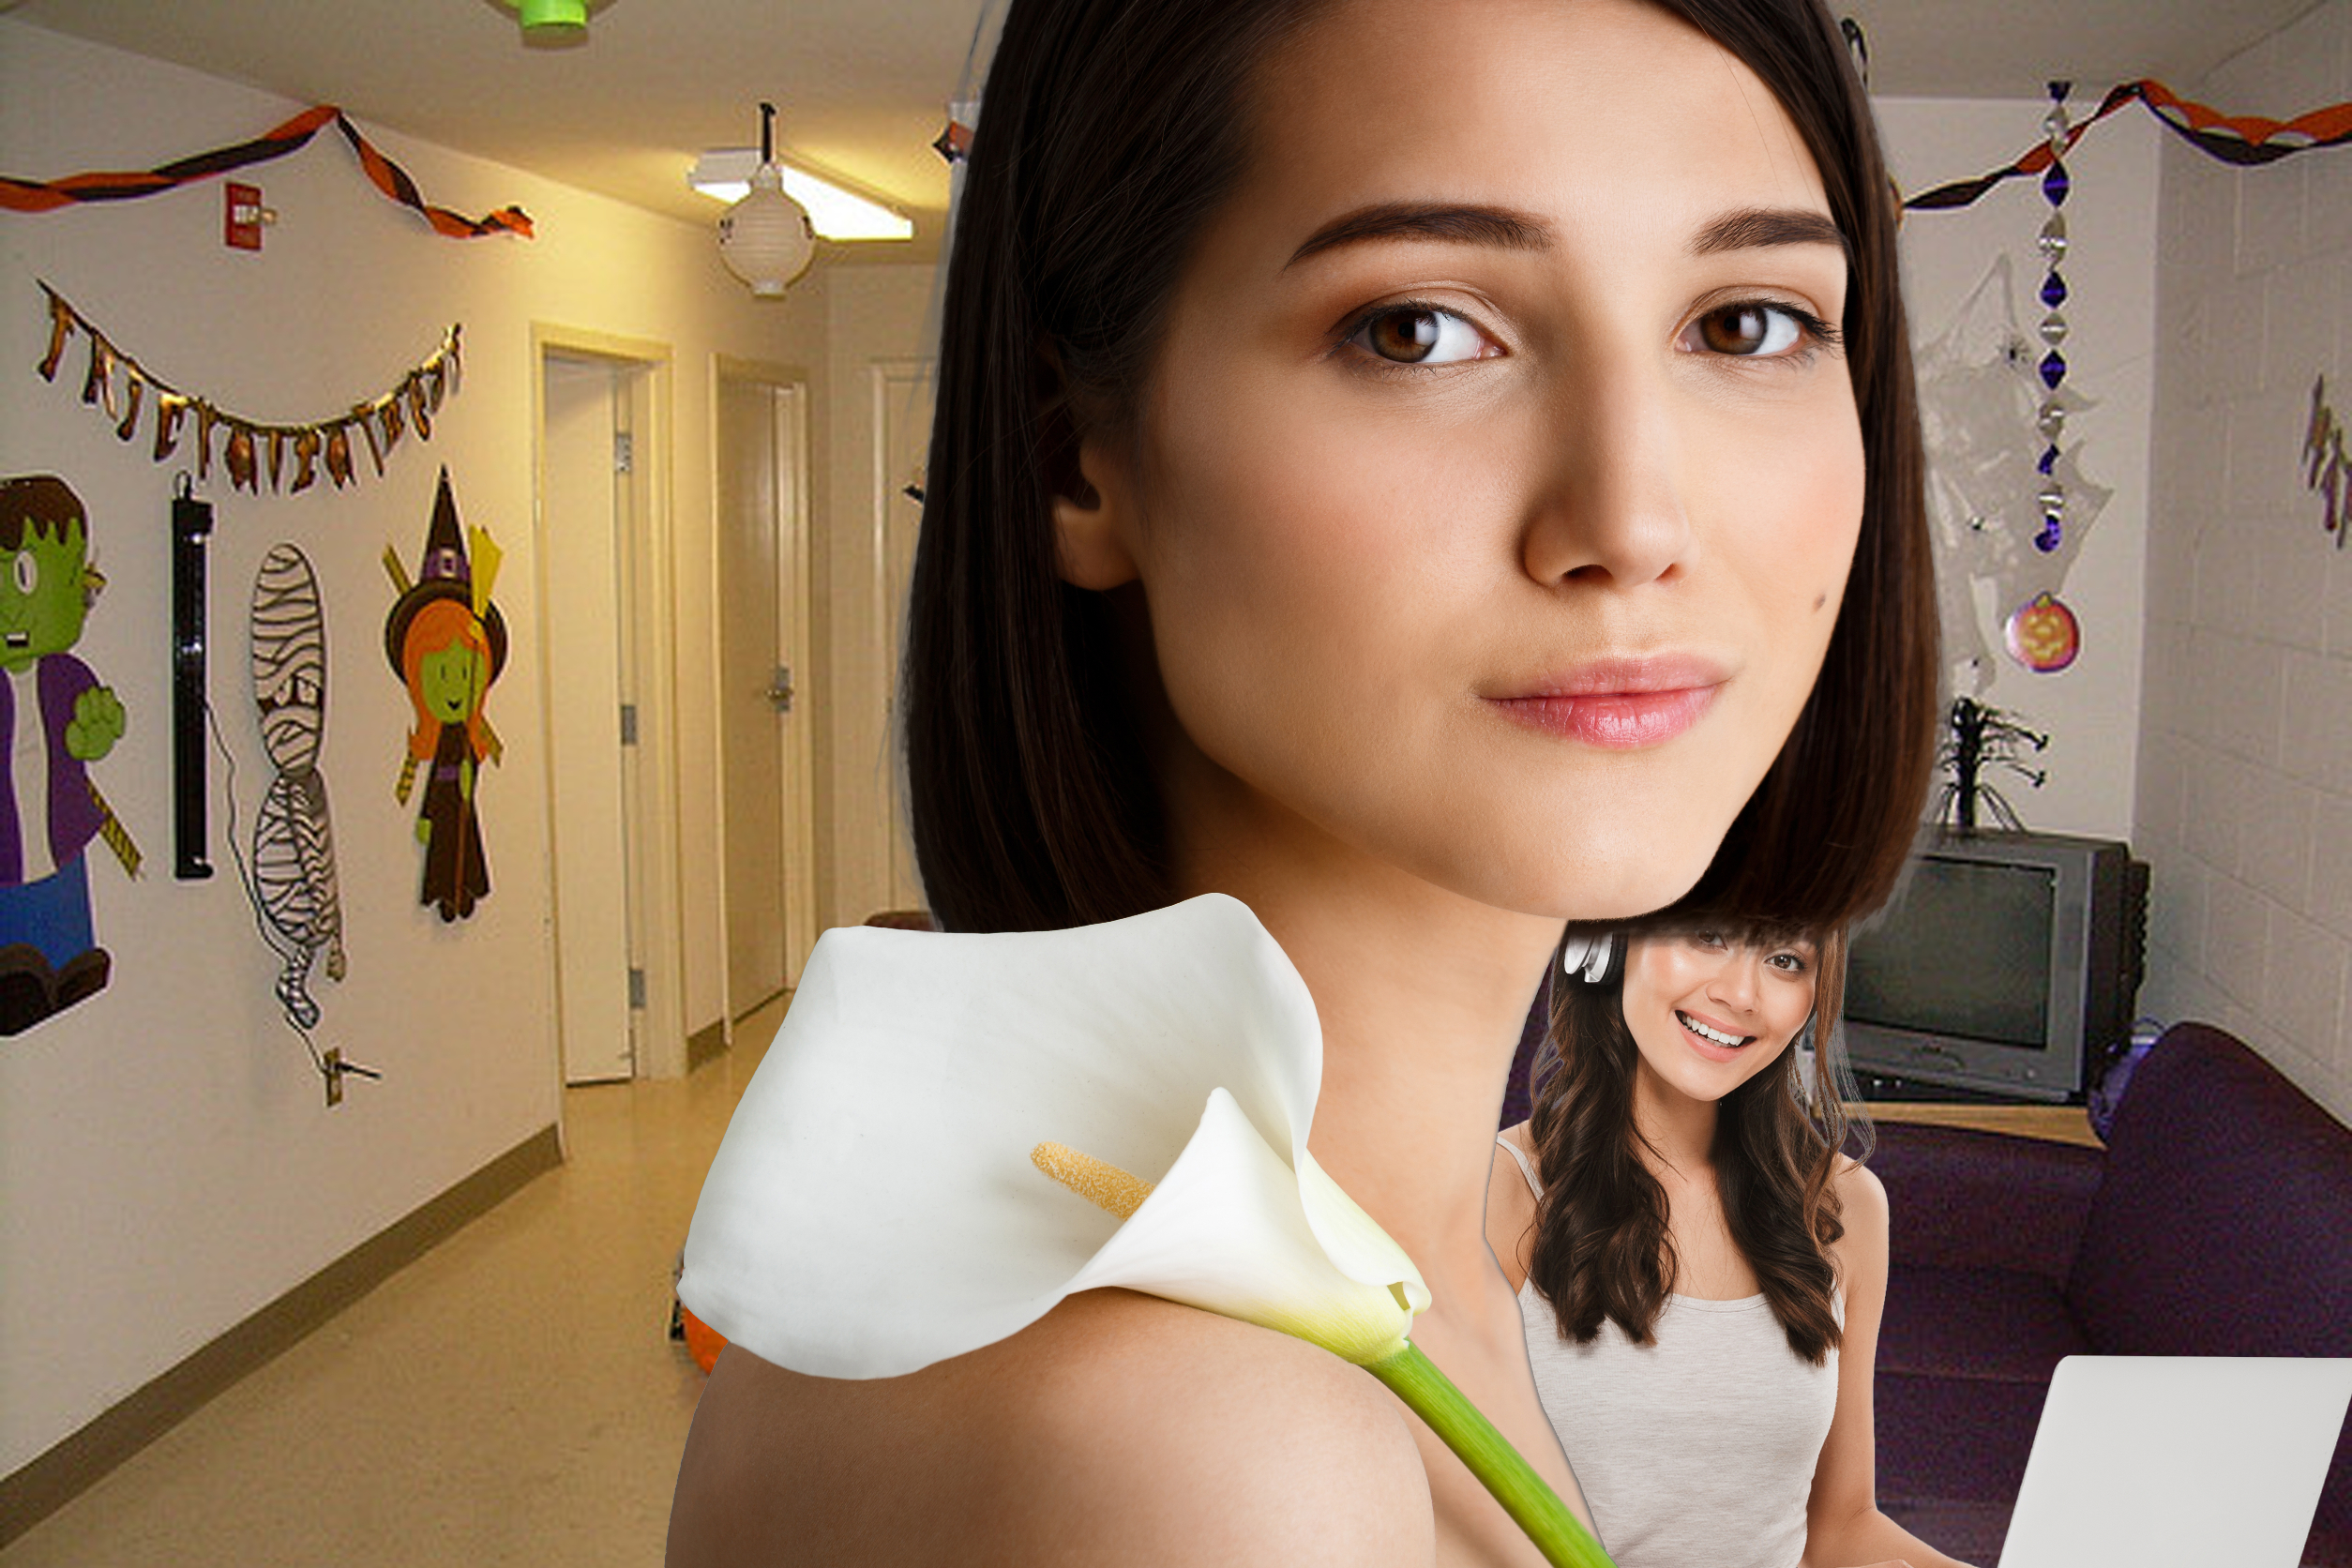

In [83]:
#aaa[0]

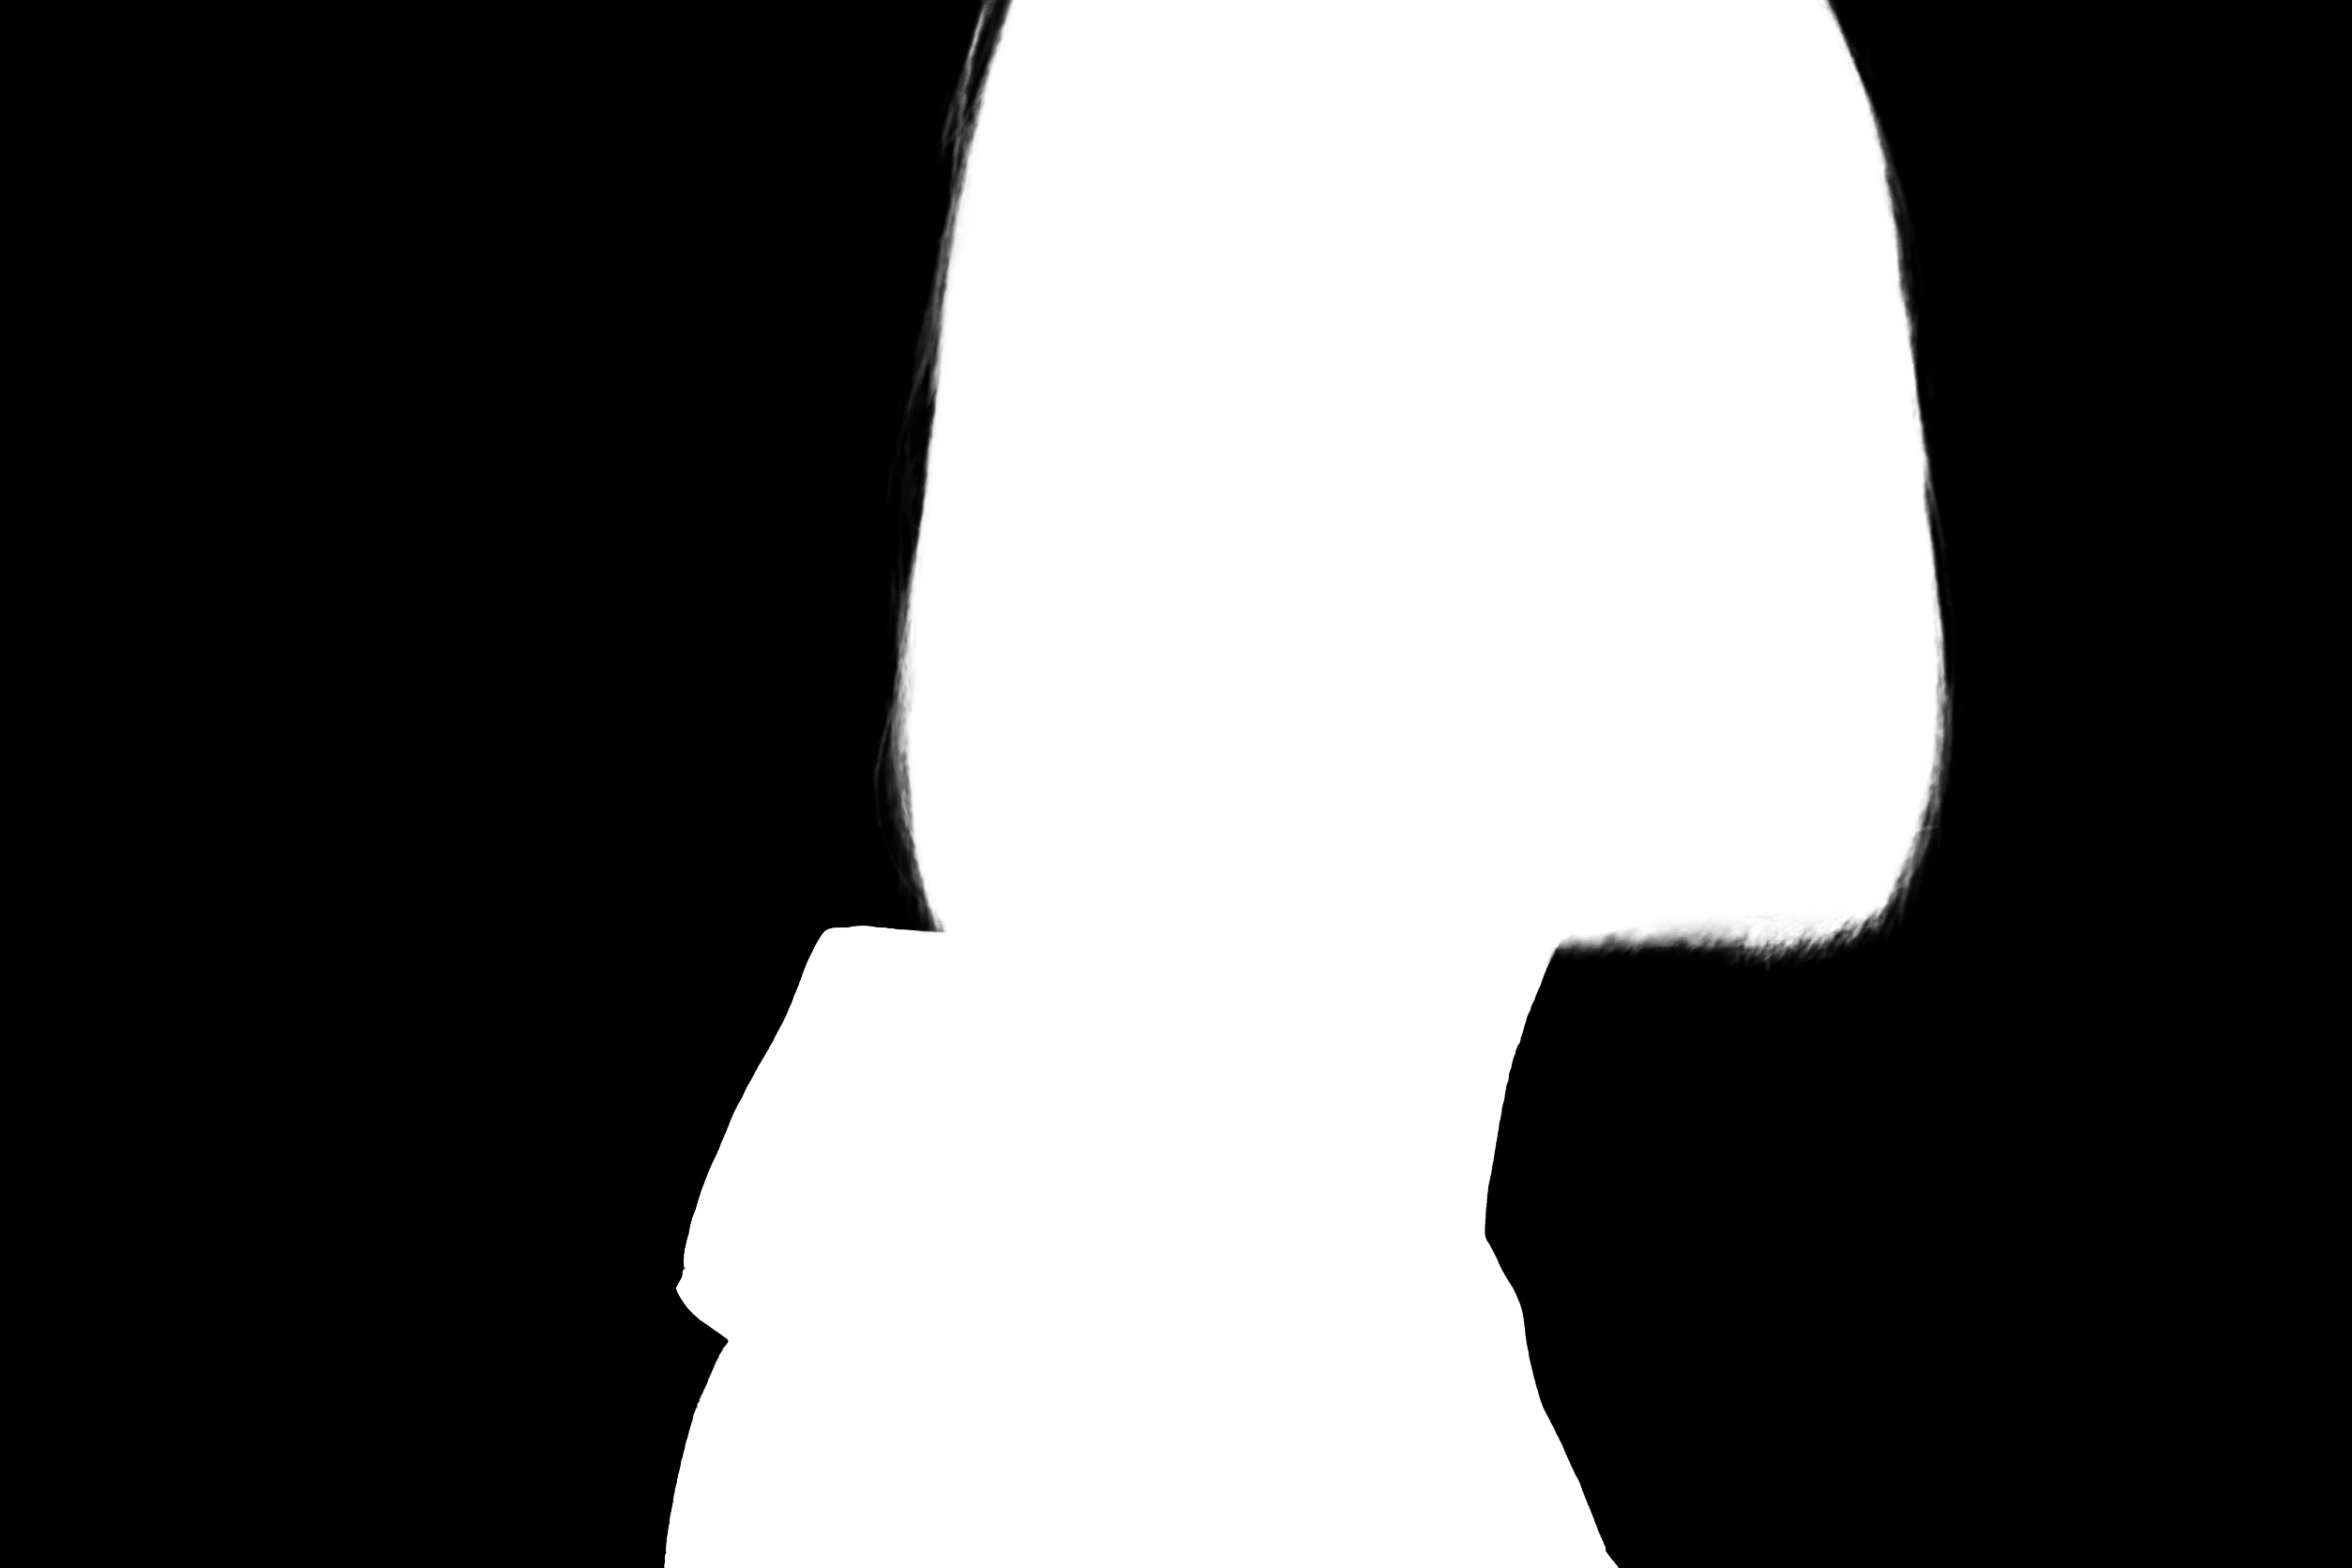

In [84]:
#aaa[1]

In [85]:
files.shape

(2250, 2)

In [12]:
generate_composite_images(fg,matte,base_path,"firstown",1250,base_path+"Heatmaps.pt")

In [8]:
'/mnt/data/Train/FG/pexels-vincenzo-giove-1925482.png'.split("/")[-1]

'pexels-vincenzo-giove-1925482.png'

In [ ]:
#delete_listed_files(own_file,fg,matte)

In [ ]:
#a,b=13,19
#a_img, a_alpha, b_img, b_alpha = files["FG"][a],files["Alpha"][a],files["FG"][b],files["Alpha"][b]

In [14]:
from torchvision import transforms

# 定义图像转换
transform = transforms.Compose([
    transforms.ToTensor(),
    # 可以添加其他的转换操作，比如归一化等
])

# 加载模型并设置为评估模式
model = keypointrcnn_resnet50_fpn(pretrained=True).eval()
model.cuda()
torch.set_grad_enabled(False)
i = 101

path = files["FG"][i]
print(path)
#image = Image.open(path).convert("RGB")
image = Image.open(path)
# 对图像进行转换
image_tensor = transform(image).unsqueeze(0).cuda()  # 添加额外的维度并移动到 GPU 上

# file_name = path.split('/')[-1]  # 这行代码没有用到，可以删除

# 模型预测
output = model(image_tensor)
if len(output[0]['keypoints']) > 0:  # 确保至少检测到一个目标
    keypoints = output[0]['keypoints'][0].cpu().numpy()  # 只处理第一个检测到的目标
    visualize_keypoints(p15, keypoints)
#keypoints

/mnt/data/Test/Comp/attractive-man-with-blue-eyes-smiling-with-joy-showing-ok-sign-with-both-hands-glad-after-meeting-with-his-girlfriend-isolated-human-facial-expressions-emotions_1.png


NameError: name 'visualize_keypoints' is not defined